1. **Install Required Packages**

In [ ]:
!source pip install tensorflow==2.8.0
!source pip install gym
!source pip install keras
!source pip install stable-baselines3
!source pip install numpy
!source pip install copy
!source pip install keras-rl
!source pip install ray
!pip install keras-rl2

2. **Import Required Dependencies**

In [ ]:
import gym
import random
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

# RL agent dependencies
from gym import Env
from gym.spaces import Discrete, Box
from scipy.sparse import csr_matrix

# DNN dependencies
import keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, Conv2D
from tensorflow.keras.optimizers.legacy import Adam

# import callbacks
from keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import Callback

# Keras-RL dependencies
from keras import __version__
tensorflow.keras.__version__ = __version__
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

3. **Define Some Functions and Problem Data**

In [ ]:
# Function to make e vector
def eMaker(size, position):
    e = np.zeros(size)
    e[position] = 1
    return e

# Function falttening A matrix
def flatten(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

# Function to calculate Obj Function value
def cal_obj(A, b, x, phi):
    A_part_f = np.floor(np.dot(phi, A))
    Ax_part_f = np.dot(A_part_f, x)
    b_part_f = np.floor(np.dot(phi, b))
    return Ax_part_f - b_part_f

def softmax(x):
  e_x = np.exp(x)
  return e_x / e_x.sum()

# Global parameters
_m = 10 # Max variables size (or constraint sizes)
_n = 5 # Max x size
_M = 1000 # Max capacity
aij_l = -5 # Lower limit on A coefficients values
aij_u = 20 # Upper limit on A coefficients values
bi_l = -20 # Lower limit on b values
bi_u = 100 # Upper limit on b values


# Data Import for Training (data generated before and stored)
I = pd.read_csv('train_1.csv')
A_train = I[[f'A{i}' for i in range(1, _n+1)]].values
b_train = I['b'].values
x_train = I['x'].values[:_n]
phi_train = I['phi'].values


# Create the state to track
state_track = [2, 72, 41, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0] + flatten(A_train) + list(b_train) + list(x_train)

4. **Parameters settings**

In [ ]:
FinalReward = False
discount_factor = 0.8
learning_rate = 1e-2
epsilon = 0.6
tau = 1
_M = 1000 # Max capacity

5. **Create the DDN for Q-value**

In [ ]:
state_shape = _m+3 + _m*_n + _m + _n
action_size = _m+1

def Q_DNN(state, actions):
  q_model = Sequential()
  q_model.add(Dense(200, activation='relu', input_shape=(1, state)))
  q_model.add(LeakyReLU(alpha=0.3))

  q_model.add(Dense(100, activation='relu'))
  q_model.add(LeakyReLU(alpha=0.3))

  q_model.add(Dense(80, activation='relu'))
  q_model.add(LeakyReLU(alpha=0.3))

  q_model.add(Dense(60, activation='relu'))
  q_model.add(LeakyReLU(alpha=0.3))

  q_model.add(Dense(40, activation='relu'))
  q_model.add(LeakyReLU(alpha=0.3))

  q_model.add(Dense(_m+1, activation='relu'))
  q_model.add(LeakyReLU(alpha=0.3))

  q_model.add(Flatten())
  return q_model

DNN = Q_DNN(state_shape, action_size)

6. **Create the RL evironment**

In [ ]:
class ChavatalEnv(Env):
    def __init__(self, A, b, x, DNN_model=None):  # Initializations in the environmen
        # Appropriate len of phi
        self.A = A
        self.b = b
        self.x = x
        self.constr = self.A[~np.all(self.A==0,axis=1),:].shape[0]
        # Flat
        self.Abx_flat = flatten(self.A) + list(self.b) + list(self.x)

        # Give model to env
        self.DNN_model = DNN_model
        self.state_track_Q = []

        # Set render mode as non cus do not need it
        self.render_mode = None

        # All the actions we can take
        self.action_space = Discrete(_m+1)

        #
        self.obj = []

        # All the possible states
        # The order is [current node, capacity, node 1 visit, ..., node _m visit, node _m+1 visit, Abx flat]
        low = np.array((_m + 3)*[0] + self.Abx_flat)
        high = np.array([_m+1]+(_m+2)*[_M] + self.Abx_flat)
        self.observation_space = Box(low=low, high=high, dtype=np.float16)

    def step(self, action):# All events within a step
        C_old = copy.deepcopy(self.state[2:_m+2])

        # Update state
        new_state = copy.deepcopy(self.state)
        new_state[0] = action
        new_state[1] += 1
        new_state[action+2] += 1
        self.state = new_state
        C = self.state[2:_m+2]


        A_part = np.dot(C, self.A/_M)
        Ax_part = np.dot(A_part, self.x)
        b_part = np.dot(C, self.b/_M)

        A_part_old = np.dot(C_old, self.A/_M)
        Ax_part_old = np.dot(A_part_old, self.x)
        b_part_old = np.dot(C_old, self.b/_M)

        if FinalReward:
            # Calculate the reward
            reward = -1
        else:
            # Calculate the reward
            reward = (Ax_part - Ax_part_old) - (b_part - b_part_old)

        # If instance 1 is training, cal Q
        normed_Q = softmax(self.DNN_model.predict(np.array(state_track).reshape((1,1,78))))
        self.state_track_Q.append(normed_Q)

        # Update termination criterion
        if action == _m:
          done = True
          if FinalReward:
              reward = Ax_part - b_part
          # Calculate obj
          self.obj.append(cal_obj(self.A, self.b, self.x, self.state[2:_m+2]/_M))
        elif self.state[1] >= _M:
          done = True
          # Calculate obj
          self.obj.append(cal_obj(self.A, self.b, self.x, self.state[2:_m+2]/_M))
        else:
          done = False

        # Set placeholder for info
        info = {}

        # Return step information
        return self.state, reward, done, info

    def render(self):  # Visualizations. It is optional depending on the problem.
        pass

    def reset(self):  # Reseting the environment after each episode.
        # Reseting the state
        temp_state = np.array((_m + 3)*[0] + self.Abx_flat)
        self.state = copy.deepcopy(temp_state)
        return self.state
env = ChavatalEnv(A_train, b_train, x_train, DNN)

7. **Build Agent with Keras_RL**

In [ ]:
def build_agent(model, actions):
    #policy = BoltzmannQPolicy(tau=tau)
    policy = EpsGreedyQPolicy(epsilon)

    # Define your memory buffer with the desired batch size
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=1000,
                   target_model_update=learning_rate, gamma=discount_factor)
    return dqn

dqn = build_agent(DNN, action_size)
dqn.compile(Adam(lr=learning_rate), metrics=['mse'])

8. **Define a callback class to drive and save the loss metrics**

In [ ]:
class LossCallback(Callback):
    def __init__(self):
        super().__init__()
        self.losses = []

    def on_batch_end(self, batch, logs=
                     None):
        self.losses.append(logs['metrics'])
        # print(f'Batch {batch + 1} - metrics: {logs["metrics"]}')

# Instantiate the LossCallback
loss_callback = LossCallback()

# Saving history log
csv_logger = CSVLogger('/content/drive/MyDrive/virtual_env/dqn_log_1.csv', append=True, separator=',')

9. **Fit DQN**

In [ ]:
dqn.fit(env, nb_steps=50000, visualize=False, verbose=0, callbacks=[csv_logger, loss_callback])

10. **Test DQN**

In [ ]:
dqn.test(env, nb_episodes=1, visualize=False)
print(env.state[2:_m+2])
print(cal_obj(A_train, b_train, x_train, env.state[2:_m+2]/_M))

Testing for 1 episodes ...
Episode 1: reward: -0.200, steps: 1000
[1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
-0.0002000000000030866


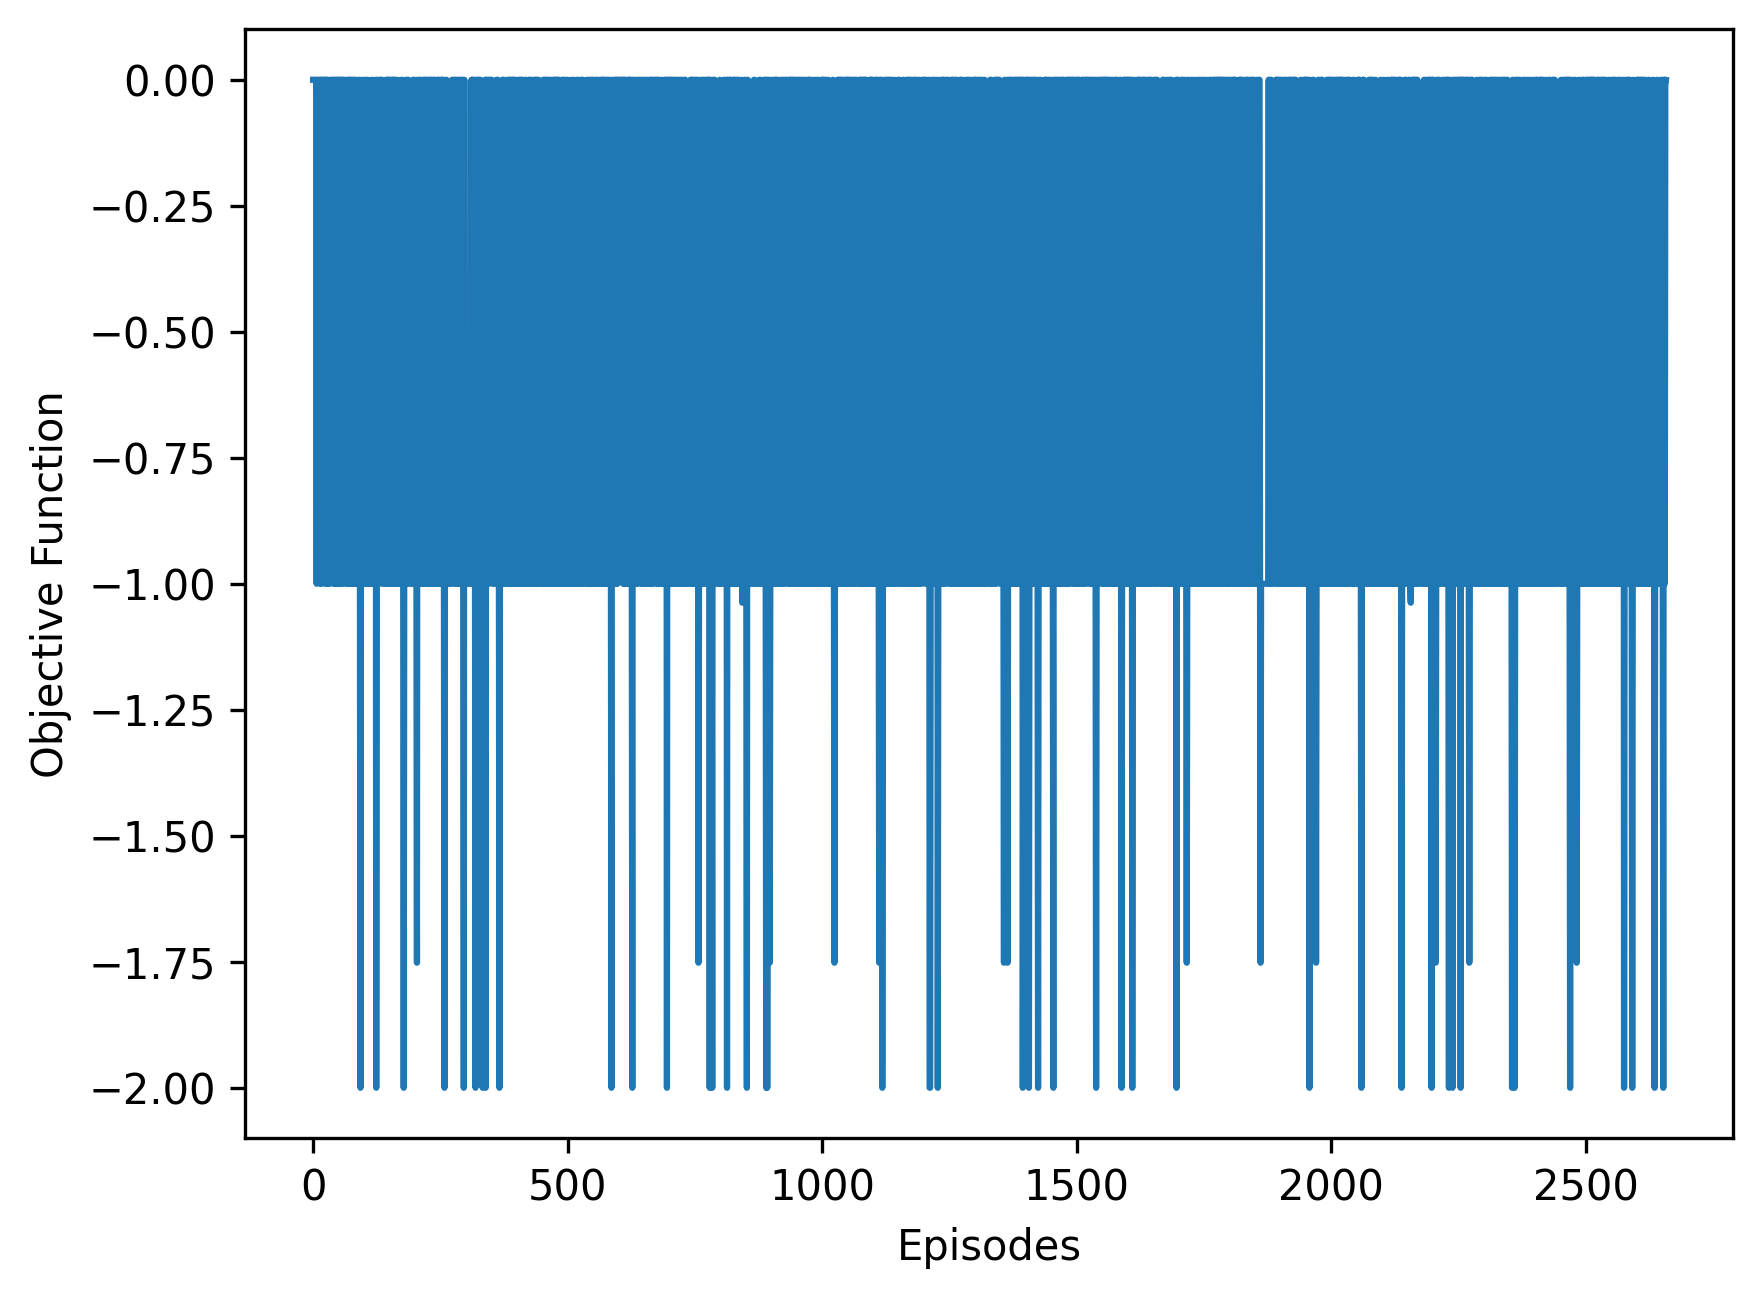

In [ ]:
plt.figure(dpi=300)
plt.plot(env.obj)
plt.ylabel('Objective Function')
plt.xlabel('Episodes')
plt.show()

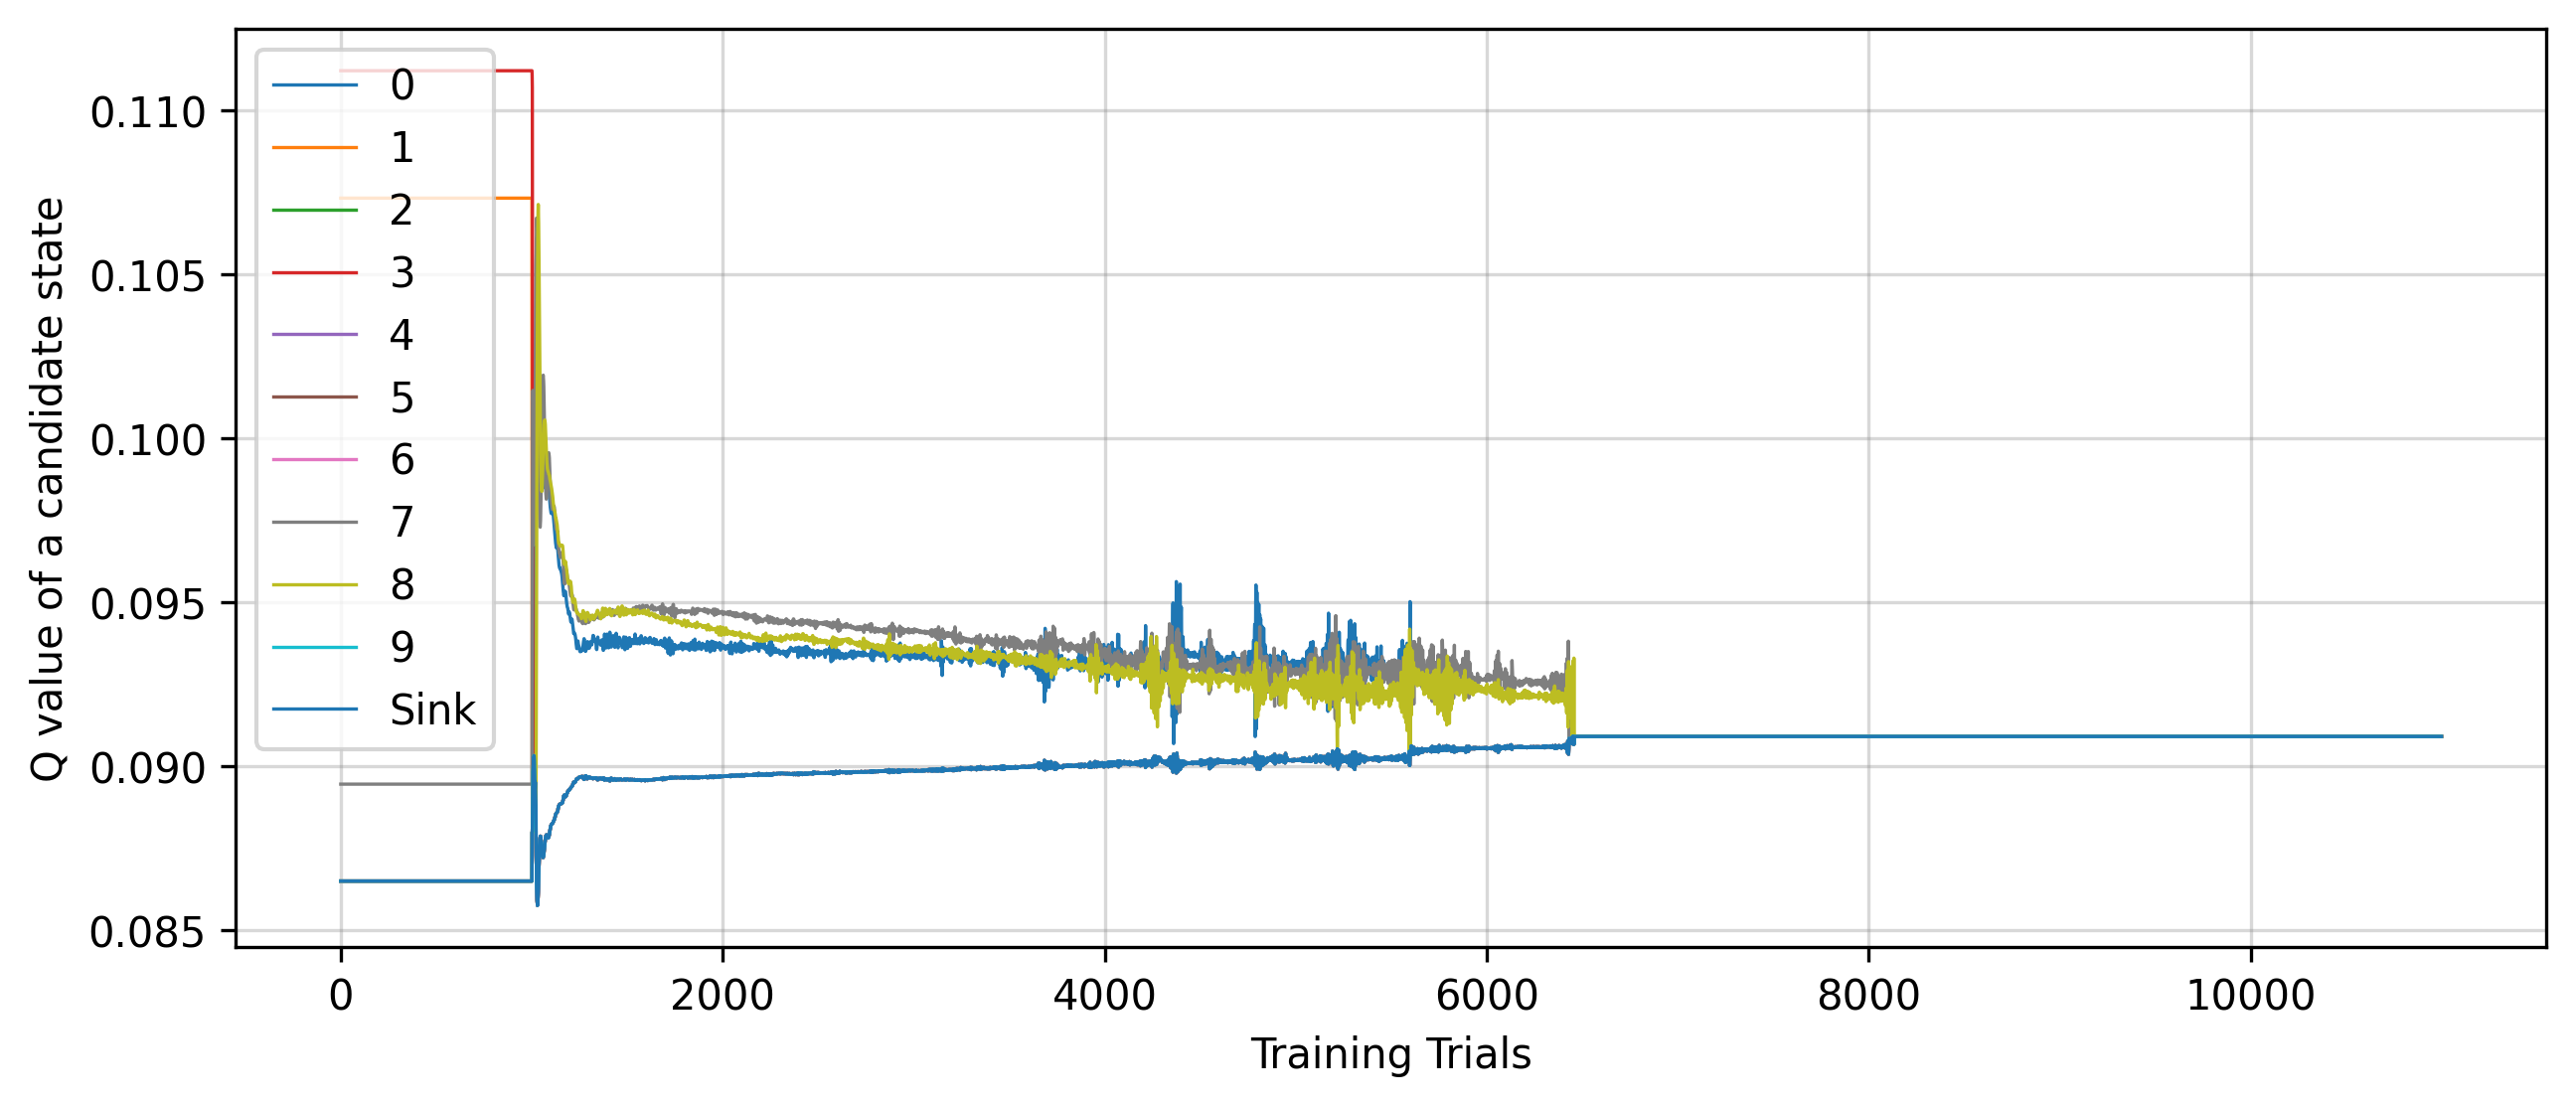

In [ ]:
# Drive the Q-values
state_track_a = env.state_track_Q
track_a = {i: [state_track_a[j][0][i] for j in range(len(state_track_a))] for i in range(11)}

# Plot Q value
plt.figure(figsize=(10, 4), dpi=300)
for i in range(11):
  if i != 10:
    label = i
  else:
    label = 'Sink'
  plt.plot(pd.DataFrame(track_a)[i], label=label, linewidth=0.8)
plt.legend()
plt.xlabel('Training Trials')
plt.ylabel('Q value of a candidate state')
plt.grid(color='gray', alpha=0.3)

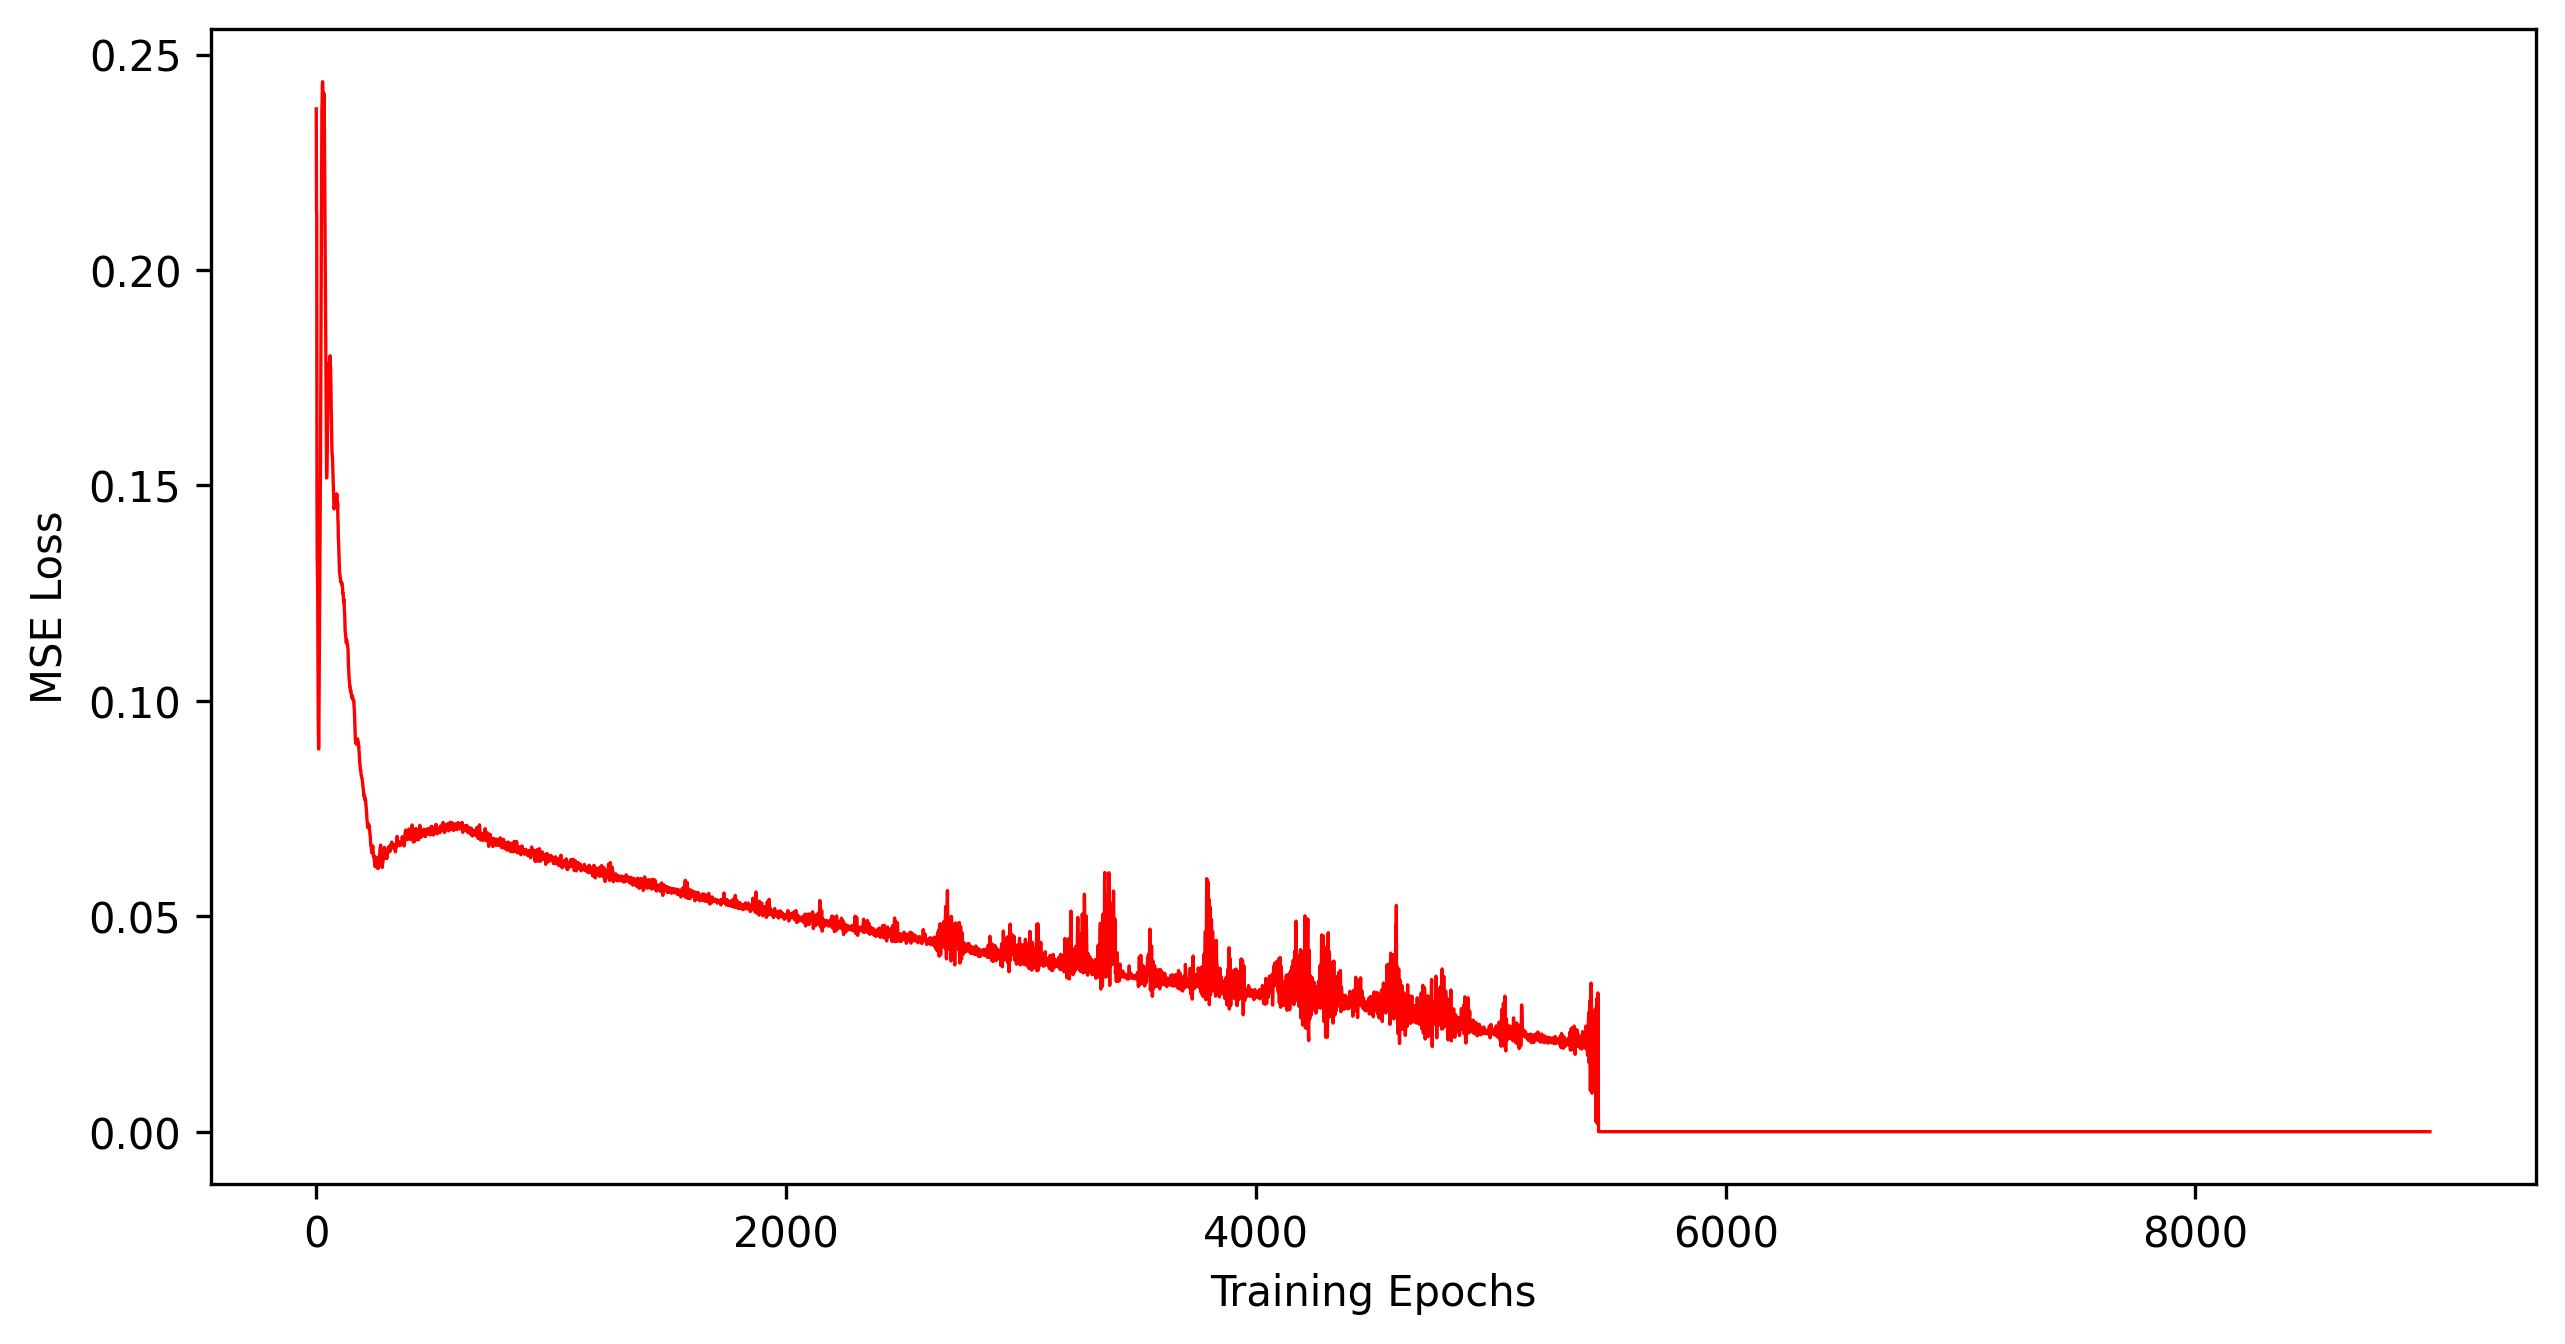

In [ ]:
# Get losses
l = np.array(loss_callback.losses)
ln = l[~np.isnan(l).any(axis=1),:]
d = pd.DataFrame(ln, columns=[1,2,3])

# Plotting the training part
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(d[3], color='red', linewidth=0.8)
plt.xlabel("Training Epochs")
plt.ylabel("MSE Loss")
plt.grid(color='gray', alpha=0.3)
plt.show()


**4. Save DQNAgent Parameters**

In [ ]:
dqn.save_weights(f'/content/drive/MyDrive/virtual_env/dqn_weights_{train_instances}.h5f', overwrite=True, )

**5. Reloading Agent from Memory**

In [ ]:
env_test = ChavatalEnv(is_test=True)
env_test.reset()

state_shape = env_test.observation_space.shape[0]
action_size = env_test.action_space.n

DNN_test = Q_DNN(state_shape, action_size)

dqn_test = build_agent(DNN_test, action_size)
dqn_test.compile(Adam(lr=1e-2), metrics=['mse'])

dqn_test.load_weights(f'/content/drive/MyDrive/virtual_env/dqn_weights_{train_instances}.h5f')

In [ ]:
# Dictionaries to save the test result
dqn_opt_phi = {i: [] for i in range(1, test_instances+1)}
dqn_opt = {'Instance': [],
               'DQN obj': [],
               'OPT obj': [],
               'gap':[]}

# Reset the env for test and test it
env_test.test_reset()
dqn_test.test(env_test, nb_episodes=5, visualize=False)

# Report the test results
for index in range(len(env_test.test_instances)):
    ins_num = env_test.test_instances[index]
    ins_dqn = env_test.test_results[index][2:_m+2]

    dqn_opt_phi[ins_num].append([np.divide(ins_dqn, _M), phi_test[ins_num]])

    dqn_obj = cal_obj(A_test[ins_num], b_test[ins_num], x_test[ins_num], np.divide(ins_dqn, _M))
    opt_obj = cal_obj(A_test[ins_num], b_test[ins_num], x_test[ins_num], phi_test[ins_num])

    dqn_opt['Instance'].append(ins_num)
    dqn_opt['DQN obj'].append(dqn_obj)
    dqn_opt['OPT obj'].append(opt_obj)
    if opt_obj == 0:
        dqn_opt['gap'].append((opt_obj - dqn_obj))
    else:
        dqn_opt['gap'].append((opt_obj - dqn_obj)/opt_obj)



# Save the report
pd.DataFrame(dqn_opt).to_csv(f'/content/drive/MyDrive/virtual_env/dqn_opt_{train_instances}.csv')
with open(f'/content/drive/MyDrive/virtual_env/dqn_opt_phi_{train_instances}.pkl', 'wb') as handle:
    pickle.dump(dqn_opt_phi, handle)
handle.close()

Testing for 5 episodes ...
Episode 1: reward: 0.000, steps: 100
Episode 2: reward: 0.000, steps: 100
Episode 3: reward: 0.000, steps: 100
Episode 4: reward: 0.000, steps: 100
Episode 5: reward: 0.000, steps: 100


In [ ]:
dqn_opt_phi

{1: [[array([0.73, 0.  , 0.  , 0.  , 0.27, 0.  , 0.  , 0.  , 0.  , 0.  ]),
   array([-0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.])],
  [array([0.73, 0.  , 0.  , 0.  , 0.27, 0.  , 0.  , 0.  , 0.  , 0.  ]),
   array([-0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.])],
  [array([0.73, 0.  , 0.  , 0.  , 0.27, 0.  , 0.  , 0.  , 0.  , 0.  ]),
   array([-0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.])]],
 2: [[array([0.85, 0.  , 0.  , 0.  , 0.15, 0.  , 0.  , 0.  , 0.  , 0.  ]),
   array([0.029, 0.646, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
          0.   ])],
  [array([0.85, 0.  , 0.  , 0.  , 0.15, 0.  , 0.  , 0.  , 0.  , 0.  ]),
   array([0.029, 0.646, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
          0.   ])]],
 3: []}